In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import torch
import itertools

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

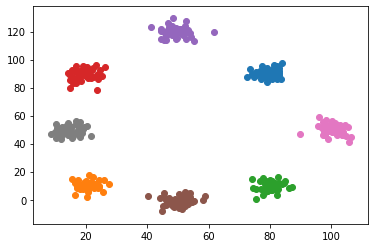

In [3]:
n_samps = 50

means = np.array([[8,9], [2,1], [8,1], [2,9], [5,12], [5,0], [10, 5], [1.5,5]]) * 10
data = np.zeros((len(means)*n_samps,2))
y = np.zeros((len(means)*n_samps,1))
for ind, m in enumerate(means):
    samps = multivariate_normal(m, np.eye(2)/0.1).rvs(n_samps)#.astype(int)
    data[ind*n_samps:((ind+1)*n_samps)] = samps
    y[ind*n_samps:((ind+1)*n_samps)] = np.tile(ind, n_samps).reshape(-1,1)
    plt.scatter(samps[:,0], samps[:,1])


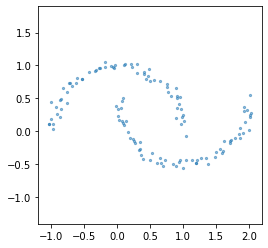

In [300]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetSIGGRAPH:
    """ 
    haha, found from Eric https://blog.evjang.com/2018/01/nf2.html
    https://github.com/ericjang/normalizing-flows-tutorial/blob/master/siggraph.pkl
    """
    def __init__(self):
        with open('siggraph.pkl', 'rb') as f:
            XY = np.array(pickle.load(f), dtype=np.float32)
            XY -= np.mean(XY, axis=0) # center
        self.XY = torch.from_numpy(XY)
    
    def sample(self, n):
        X = self.XY[np.random.randint(self.XY.shape[0], size=n)]
        return X

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

def eightMixture_sample(batch_size):
    rand = np.random.choice(np.arange(len(data)), batch_size)
    return data[rand,:]

def oh_eightMixture_sample(batch_size):
    rand = np.random.choice(np.arange(len(oh)), batch_size)
    return oh[rand,:]
    
d = DatasetMoons()
#d = DatasetMixture()
#d = DatasetSIGGRAPH()

x = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [130]:
def torch_oh(input, vocab_size, axis=-1):
    input = input-input.min()
    x = input.flatten().unsqueeze(1).long()
    z = torch.zeros((input.shape[0]*input.shape[1], vocab_size ))
    z.scatter_(1,x,1)
    z = z.view(input.shape[0], input.shape[1], vocab_size)
    return z

torch.Size([64, 2])


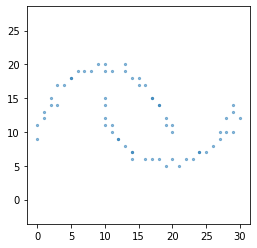

In [131]:
import disc_utils
ds_moons = DatasetMoons()
moons_vocab_size = 35
# need to make one hot. 
def int_moons_sample(batch_size):
    x = ds_moons.sample(batch_size)*10
    x = x.type(torch.int)
    x = torch_oh(x, moons_vocab_size, axis=-1)
    return x

x = int_moons_sample(64).argmax(-1)
print(x.shape)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [82]:
print(x.max(), x.min())

tensor(20, dtype=torch.int32) tensor(-10, dtype=torch.int32)


In [5]:
data.shape

(400, 2)

In [6]:
batch_size, sequence_length, vocab_size = 32,  2, 150

def one_hotter(x, depth):
    idd = np.eye(depth)
    #print(idd[0])
    res = np.zeros((x.shape[0], x.shape[1], depth))
    #print(res.shape)
    for ind in range(len(x)): 
        for j, val in enumerate(x[ind]):
            res[ind, j, :] = idd[int(val)]
            
    return res
            

oh = one_hotter(data, vocab_size)

In [178]:
from MADE import *
from flows import *
from spline_flows import NSF_AR, NSF_CL

base = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))

# RealNVP
#flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]

# NICE
#flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(4)]
#flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(4)]

# MAF (with MADE net, so we get very fast density estimation)
flows = [MAF(dim=2, parity=i%2) for i in range(4)]

# Neural splines, coupling
'''nfs_flow = NSF_CL if True else NSF_AR
flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
convs = [Invertible1x1Conv(dim=2) for _ in flows]
norms = [ActNorm(dim=2) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))'''


model = NormalizingFlowModel(base, flows)

In [784]:
torch.rand(5,10).sum(-1)

tensor([5.7048, 5.7310, 5.9984, 5.5971, 4.9795])

In [8]:
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  5488


In [9]:
base.sample((100,));

In [10]:
type(torch.Tensor(data[:batch_size,:]))

torch.Tensor

forward is from data to latent. backward is from latent to data

In [11]:
epochs = 15000
batch_size = 248
learning_rate=0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

#x = torch.Tensor(data[:batch_size,:])

model.train()
for e in range(epochs): 
    
    #x = d.sample(batch_size)
    x = torch.Tensor(eightMixture_sample(batch_size))
    
    optimizer.zero_grad()
    
    zs, prior_logprob, log_det = model.forward( x )
    # get the back output after every transformation currently!
    #print(back_probs)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob)
    #print(loss)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach())
    
    if e%100==0:
        print(e, loss.item())
    
    
plt.plot(losses)
    

0 31729980.0
100 5319970.0
200 3094805.75
300 2209843.0
400 1703109.375
500 1372396.625
600 1205545.25
700 1101721.5
800 970992.875
900 872133.75
1000 701831.6875
1100 692740.75
1200 590573.3125
1300 559430.3125
1400 567803.0
1500 511533.375
1600 462751.75
1700 457484.46875
1800 434756.0


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-1241853afd91>", line 25, in <module>
    optimizer.step()
  File "/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/torch/optim/adam.py", line 93, in step
    exp_avg.mul_(beta1).add_(1 - beta1, grad)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/IPy

KeyboardInterrupt: 

Text(0.5, 1.0, 'z -> x')

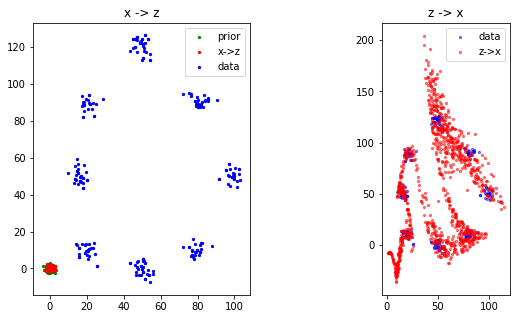

In [54]:
model.eval()

#x = d.sample(128)
x = torch.Tensor(eightMixture_sample(batch_size))
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

zs = model.sample(128*8)
z = zs[-1]
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

In [62]:
def plot2D(x):
    plt.scatter(x[:,0], x[:,1])
    plt.show()

In [11]:
x = eightMixture_sample(batch_size)
plot2D(x)

NameError: name 'eightMixture_sample' is not defined

In [12]:
model.eval()

samps = model.sample(batch_size)[-1]
samps = samps.detach().numpy()
plot2D(samps)

NameError: name 'plot2D' is not defined

In [13]:
samps;

# Discrete Flows

In [285]:
from TorchDiscCode import *

In [468]:
num_flows = 6

In [762]:
nh = 64
batch_size= 1024
sequence_length = 2
vocab_size = 35
temperature = 0.1
flows = []

for i in range(num_flows):
    # if want to also learn the scale: 
    # MADE(vocab_size, [nh, nh, nh], 2*vocab_size, num_masks=1, natural_ordering=False)
    layer = MADE(vocab_size, [nh, nh, nh], vocab_size, 
                 num_masks=1, natural_ordering=False)
    disc_layer = DiscreteAutoregressiveFlow( layer, temperature, vocab_size )
    flows.append(disc_layer)
    
model = DiscreteAutoFlowModel(flows)
    

update masks is running!
update masks is running!
update masks is running!
update masks is running!
update masks is running!
update masks is running!


In [763]:
lol = {'yo':5}
if lol:
    print('hey')

hey


In [764]:
oh[:64,:,:].shape

(64, 2, 150)

In [765]:
rand_source = torch.distributions.normal.Normal(0,1)
rand_samps = rand_source.sample([sequence_length, vocab_size])

rand_samps.shape

torch.Size([2, 35])

In [766]:
rand_samps

tensor([[-0.7809, -0.5972, -0.1277, -0.3918,  1.2931, -0.1320, -2.1199,  1.2401,
         -1.4200, -2.0162,  0.2492, -1.1044, -2.2513, -1.4013,  1.3183, -0.5886,
          2.4925, -0.6813, -0.6526,  0.4654, -0.3253, -0.1355, -0.9064,  0.0379,
          0.5015, -0.5290,  0.4340, -0.5608, -0.3272, -0.6945,  0.2437, -1.2479,
         -0.6443,  2.9989,  0.0750],
        [ 0.1824,  1.4540,  1.0473, -1.5877, -0.1166, -0.5330, -0.6660, -1.3192,
         -0.1315, -1.2770, -0.6230, -0.6125,  2.1880, -0.9111, -0.1808,  0.9664,
          0.0031,  1.1575, -1.1911, -0.5970,  0.4398,  0.5176, -0.6991, -1.3207,
          0.6543, -1.9446, -0.9175,  0.4060,  2.4581,  0.2372,  0.8302, -0.0234,
          0.7463,  2.0586, -1.0727]])

In [767]:
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform 

rand_source = TransformedDistribution(Uniform(torch.zeros(1), torch.ones(1)), SigmoidTransform().inv)
rand_samps = rand_source.sample([sequence_length, vocab_size]).squeeze()
rand_samps.shape

torch.Size([2, 35])

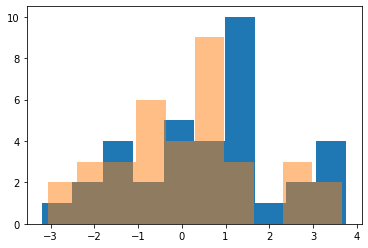

In [768]:
plt.hist(rand_samps[0,:])
plt.hist(rand_samps[1,:], alpha=0.5)
plt.show()

(array([ 20.,  37.,  27.,  24., 178., 124.,  41.,  37., 507.,  29.]),
 array([ 0. ,  3.4,  6.8, 10.2, 13.6, 17. , 20.4, 23.8, 27.2, 30.6, 34. ]),
 <a list of 10 Patch objects>)

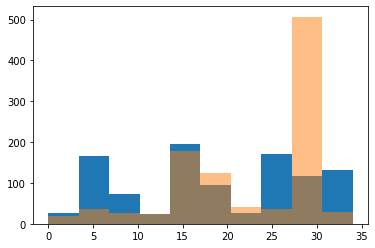

In [769]:
base = torch.distributions.OneHotCategorical(logits = rand_samps )
samps = base.sample((batch_size,)).argmax(-1)
plt.hist(samps[:,0])
plt.hist(samps[:,1], alpha=0.5)

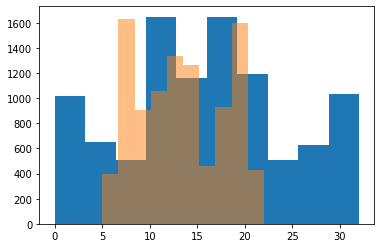

In [770]:
n_moon_samps = 10000
moon_samp = int_moons_sample(n_moon_samps).float().argmax(-1)
plt.hist(moon_samp[:,0])
#plt.show()
plt.hist(moon_samp[:,1], alpha=0.5)
plt.show()

In [771]:
import collections
import pandas as pd
moon_dim0 = collections.Counter(moon_samp[:,0].detach().numpy())
moon_dim1 = collections.Counter(moon_samp[:,1].detach().numpy())
dim0_probs = np.zeros((vocab_size))
dim1_probs = np.zeros((vocab_size))
for k, v in moon_dim0.items():
    dim0_probs[k] = v/n_moon_samps
for k, v in moon_dim1.items():
    dim1_probs[k] = (v/n_moon_samps)

dim0_probs += 0.000001
dim1_probs += 0.000001

# need to renormalize again... 


dim0_probs = dim0_probs / np.sum(dim0_probs)
dim1_probs = dim1_probs / np.sum(dim1_probs)

In [772]:
moon_probs = np.vstack([dim0_probs, dim1_probs])
'''moon_hist = moon_probs*1000
plt.hist(moon_hist[0,:])
#plt.show()
plt.hist(moon_hist[1,:], alpha=0.5)
plt.show()
'''

'moon_hist = moon_probs*1000\nplt.hist(moon_hist[0,:])\n#plt.show()\nplt.hist(moon_hist[1,:], alpha=0.5)\nplt.show()\n'

(array([1.000e+00, 3.540e+02, 1.599e+03, 9.390e+02, 1.787e+03, 1.278e+03,
        1.066e+03, 9.330e+02, 1.617e+03, 4.260e+02]),
 array([ 3. ,  4.9,  6.8,  8.7, 10.6, 12.5, 14.4, 16.3, 18.2, 20.1, 22. ]),
 <a list of 10 Patch objects>)

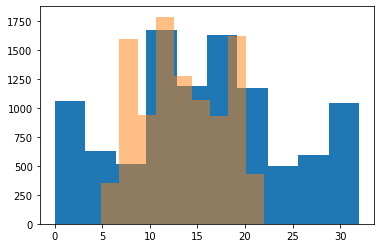

In [773]:
base = torch.distributions.OneHotCategorical(probs = torch.tensor(moon_probs).float() )
samps = base.sample((10000,)).argmax(-1)
plt.hist(samps[:,0])
plt.hist(samps[:,1], alpha=0.5)

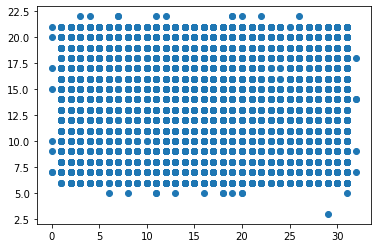

In [774]:
def plot2D(x):
    plt.scatter(x[:,0], x[:,1])
    plt.show()
    
plot2D(samps)

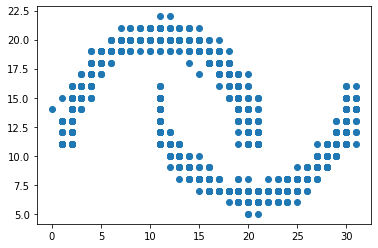

In [775]:
x = int_moons_sample(batch_size)
plot2D(x.argmax(-1))


MADE(
  (net): Sequential(
    (0): MaskedLinear(in_features=35, out_features=64, bias=True)
    (1): ReLU()
    (2): MaskedLinear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): MaskedLinear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): MaskedLinear(in_features=64, out_features=35, bias=True)
  )
)
torch.Size([35, 64])


(array([8., 9., 5., 7., 4., 8., 5., 4., 5., 9.]),
 array([-0.11896934, -0.09514498, -0.07132062, -0.04749626, -0.0236719 ,
         0.00015246,  0.02397682,  0.04780118,  0.07162554,  0.0954499 ,
         0.11927426], dtype=float32),
 <a list of 10 Patch objects>)

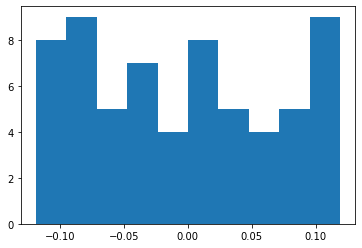

In [776]:
flow_num = 0
sub_part = 6
print(model.flows[flow_num]._modules['layer'])
w = model.flows[flow_num]._modules['layer'].net[sub_part]._parameters['weight'] 
print(w.shape)
plt.hist(w.detach().numpy()[0,:])

0 16.89152717590332


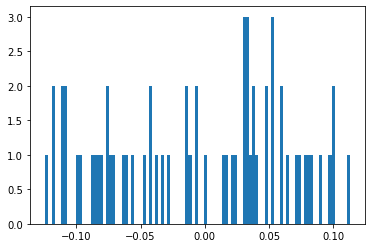

250 17.60268783569336


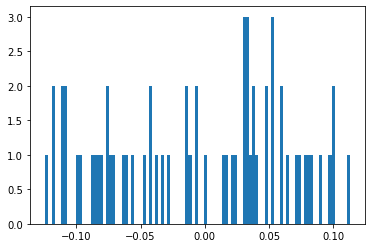

500 16.903244018554688


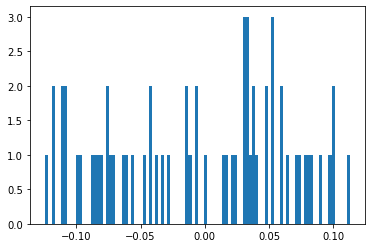

750 10.261356353759766


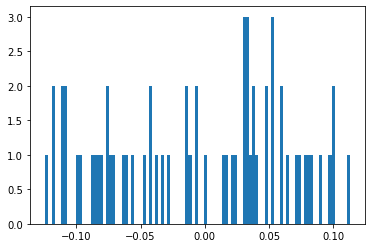

1000 10.25831413269043


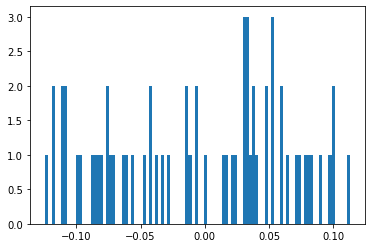

1250 10.250409126281738


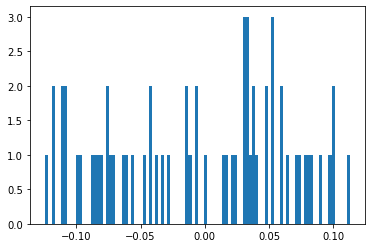

1500 10.328707695007324


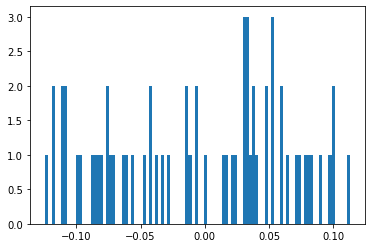

1750 9.877646446228027


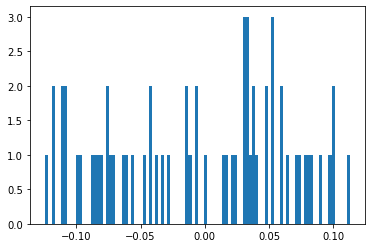

2000 10.262346267700195


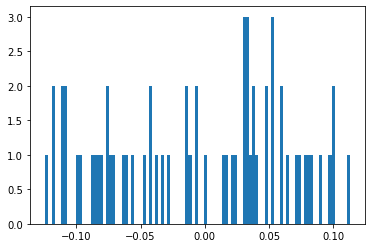

2250 10.98162841796875


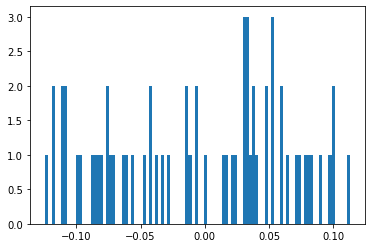

2500 10.511080741882324


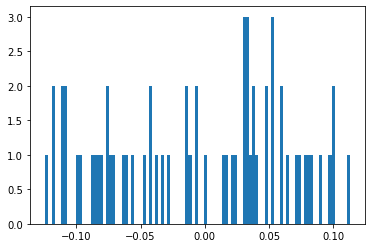

2750 10.432004928588867


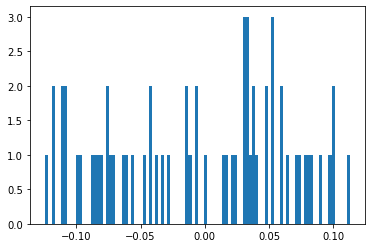

3000 10.161402702331543


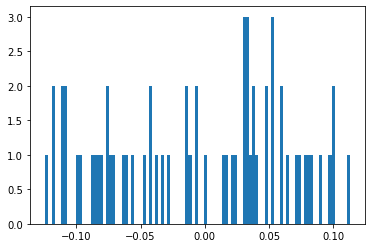

3250 9.84854507446289


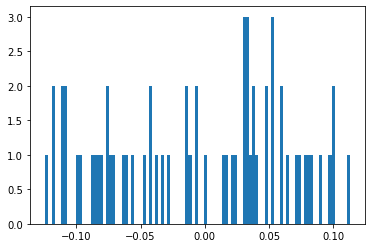

3500 9.827874183654785


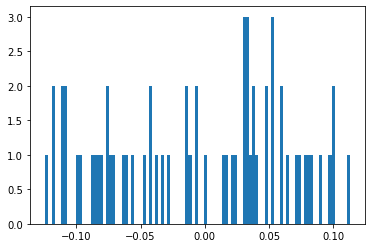

3750 9.823036193847656


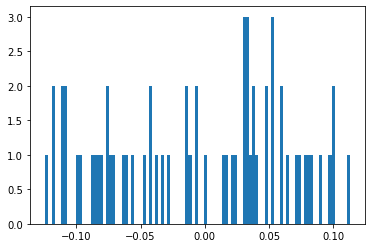

4000 9.833800315856934


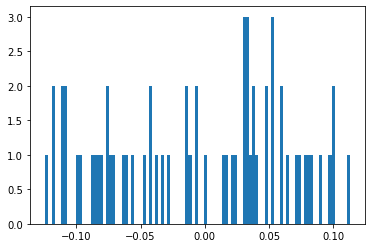

4250 9.80804443359375


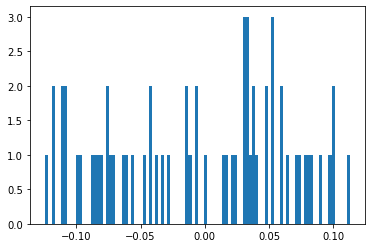

4500 10.25832748413086


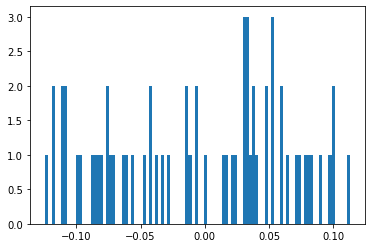

4750 10.220507621765137


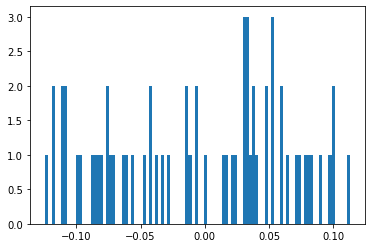

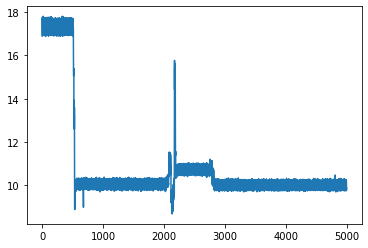

In [777]:
epochs = 5000
learning_rate =0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
weights = []
#x = torch.Tensor(data[:batch_size,:])
base_log_probs = torch.log(base.probs)
model.train()
for e in range(epochs): 
    
    #x = d.sample(batch_size)
    #x = torch.tensor(oh_eightMixture_sample(batch_size)).float()
    x = int_moons_sample(batch_size).float()
    
    optimizer.zero_grad()
    zs = model.reverse(x)
    logprob = zs*base_log_probs.float()
    loss = -torch.sum(logprob)/batch_size
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach())
    
    if e%250==0:
        print(e, loss.item())
        
        
        #plotting the weights of a single layer: 
        
        flow_num = num_flows-1
        sub_part = 6
        w = model.flows[flow_num]._modules['layer'].net[sub_part]._parameters['weight'].detach().numpy() 
        #print(w.shape)
        weights.append(w)
        plt.hist(w[0,:],bins=100)
        plt.show()
    
plt.plot(losses)
    

In [778]:
ma_loss = [losses[0]]
ind = 1
for l in losses[1:]:
    ma_loss.append( ma_loss[ind-1] +0.01*(l-ma_loss[ind-1]) )
    ind+=1

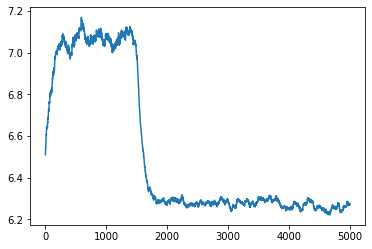

In [730]:
plt.plot(ma_loss)

(1024, 2)


(0, 35)

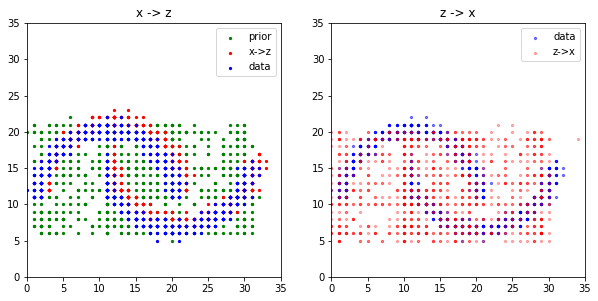

In [731]:
model.eval()

#x = d.sample(128)
x = int_moons_sample(batch_size).float()
zs = model.reverse(x)
z = zs

x = x.detach().numpy().argmax(-1)
z = z.detach().numpy().argmax(-1)
print(z.shape)
p = base.sample((batch_size,)).argmax(-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])

zs = model.forward(base.sample((batch_size,)).float())
z = zs
z = z.detach().numpy().argmax(-1)
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])

In [732]:
base.logits

tensor([[ -7.8216,  -3.8680,  -2.9977,  -3.4641,  -3.7593,  -3.8304,  -3.9322,
          -4.0398,  -4.0342,  -4.1799,  -4.1227,  -2.2966,  -2.9740,  -3.2214,
          -3.2597,  -3.3050,  -3.2781,  -3.2728,  -3.1773,  -3.0748,  -2.7196,
          -3.3382,  -4.0804,  -4.1104,  -4.1864,  -3.9120,  -4.0687,  -3.7942,
          -3.6809,  -3.4673,  -2.9957,  -3.9221,  -8.5122, -13.8155, -13.8155],
        [-13.8155, -13.8155, -13.8155, -13.8155, -13.8155,  -6.8116,  -3.1942,
          -2.3592,  -2.7121,  -3.0038,  -3.1559,  -2.2350,  -2.7458,  -2.7196,
          -2.7046,  -2.7458,  -3.0967,  -3.2571,  -2.9898,  -2.7536,  -2.3455,
          -3.1749,  -6.6447, -13.8155, -13.8155, -13.8155, -13.8155, -13.8155,
         -13.8155, -13.8155, -13.8155, -13.8155, -13.8155, -13.8155, -13.8155]])

In [733]:
'''

f.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(
                labels=model.reverse(dataset[:batch_size,:,:]), # data into latent. 
              logits=model_rv.distribution.base.logits)) # i think these are the probabilitis of the 
              # latent transformed into the data. 

'''

'\n\nf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(\n                labels=model.reverse(dataset[:batch_size,:,:]), # data into latent. \n              logits=model_rv.distribution.base.logits)) # i think these are the probabilitis of the \n              # latent transformed into the data. \n\n'

# Model learns how to map the data up to the categories well! When there are 4 layers of MADE.

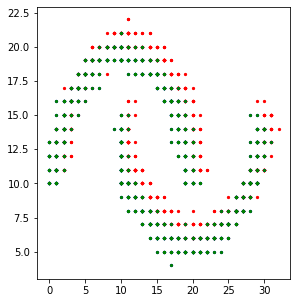

In [734]:
# making sure that the forward and reverse are in fact still invertible with each other. 

x = int_moons_sample(batch_size).float()
zs = model.reverse(x)
x_hats = model.forward(zs)

x = x.detach().numpy().argmax(-1)
z = zs.detach().numpy().argmax(-1)
x_hats = x_hats.detach().numpy().argmax(-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.scatter(x_hats[:,0], x_hats[:,1], c='g', s=5) # this is the replication

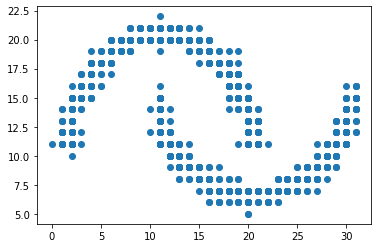

In [735]:
x = int_moons_sample(batch_size)
plot2D(x.argmax(-1))

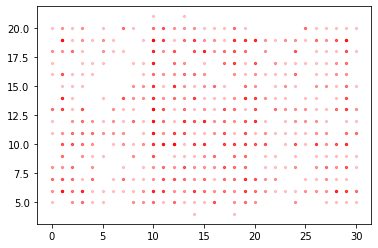

In [736]:
# smaller sample to see what happens

a = model.forward(base.sample((1000,)).float()).argmax(-1)
plt.scatter(a[:,0], a[:,1], c='r', s=5,alpha=0.2)

# Looking at the probabilities assigned to each transformed point

In [737]:
# weight each of the points by the probability that they are appearing!
samps = base.sample((batch_size,)).float()
samps_probs = torch.exp( (torch.log(base.probs) * samps).sum(-1).sum(-1) )
samps_probs.shape

torch.Size([1024])

(array([113., 335., 222., 166.,  73.,  48.,  37.,   0.,  25.,   5.]),
 array([1.3446162e-05, 1.0884672e-03, 2.1634882e-03, 3.2385092e-03,
        4.3135304e-03, 5.3885514e-03, 6.4635724e-03, 7.5385934e-03,
        8.6136144e-03, 9.6886354e-03, 1.0763656e-02], dtype=float32),
 <a list of 10 Patch objects>)

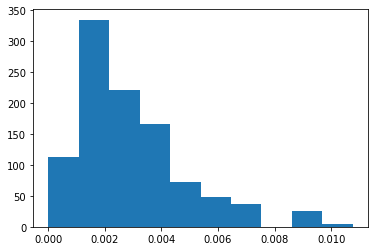

In [738]:
plt.hist(samps_probs)

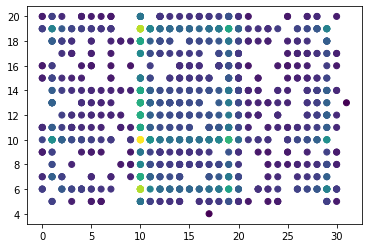

In [739]:
a = model.forward(samps).argmax(-1)
plt.scatter(a[:,0], a[:,1], c=samps_probs, cmap=plt.get_cmap('viridis'))

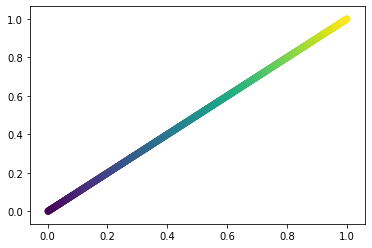

In [740]:
mu = 1/samps_probs.max().detach().numpy()
lin= np.linspace(samps_probs.min(), samps_probs.max(), batch_size)*mu
plt.scatter(lin, lin, 
            c=lin, cmap=plt.get_cmap('viridis'))

## What is the lowest loss that I should expect to see? 

In [741]:
res= []
b_size = 1000
for i in range(100):
    samps = base.sample((b_size,)).float()
    logprob = samps*base_log_probs
    res.append(-torch.sum(logprob)/b_size)
    
np.mean(np.asarray(res))

6.0429907

(0, 35)

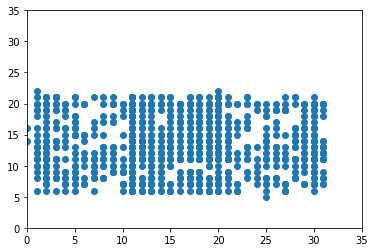

In [743]:
s = samps.argmax(-1)
plt.scatter(s[:,0], s[:,1])
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])

Text(0.5, 1.0, 'Distribution of optimal scores')

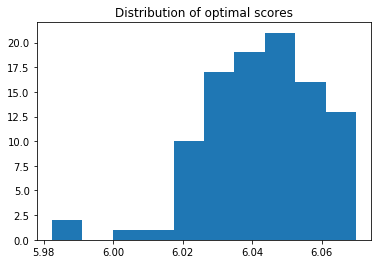

In [744]:
plt.hist(res)
plt.title('Distribution of optimal scores')

## Looking at the probability grid of the sequences

In [745]:
# what is the probability grid? 

x = np.arange(vocab_size)
xv, yv = np.meshgrid(x, x)

In [746]:
comb = np.vstack([xv.flatten(),yv.flatten()]).T
comb.shape

(1225, 2)

In [747]:
# turn into one hot and then see what the probs are. for the cateogorical. 
# then map into the data space and see. 

def onehotter(inp):
    
    x = torch.tensor(inp)
    x = x.flatten().long().unsqueeze(1)
    z = torch.zeros(inp.shape[0]*inp.shape[1], vocab_size)
    z.scatter_(1,x,1)
    z = z.view(inp.shape[0], inp.shape[1], vocab_size)
    return z

In [748]:
comb = onehotter(comb)
comb.shape

torch.Size([1225, 2, 35])

In [749]:
grid_probs = torch.exp((torch.log(base.probs) * comb).sum(-1).sum(-1))
grid_probs.shape

torch.Size([1225])

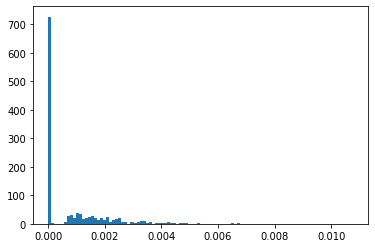

In [750]:
plt.hist(grid_probs, bins=100)
plt.show()

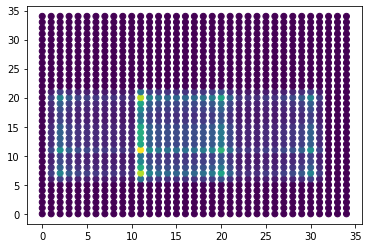

In [751]:
# this matches what the histogram outlined!
a = comb.argmax(-1)
plt.scatter(a[:,0], a[:,1], c=grid_probs, cmap=plt.get_cmap('viridis'))

(0, 35)

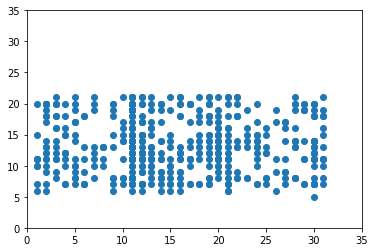

In [752]:
rand = base.sample((500,)).argmax(-1)
plt.scatter(rand[:,0], rand[:,1])
plt.xlim(0,35); plt.ylim(0,35)

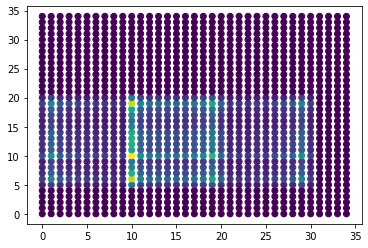

In [753]:
a = model.forward(comb).argmax(-1)
plt.scatter(a[:,0], a[:,1], c=grid_probs, cmap=plt.get_cmap('viridis'))

In [754]:
comb.argmax(-1)[0:10,:]

tensor([[0, 0],
        [1, 0],
        [2, 0],
        [3, 0],
        [4, 0],
        [5, 0],
        [6, 0],
        [7, 0],
        [8, 0],
        [9, 0]])

In [755]:
a[:10,:]

tensor([[34, 34],
        [ 0, 34],
        [ 1, 34],
        [ 2, 34],
        [ 3, 34],
        [ 4, 34],
        [ 5, 34],
        [ 6, 34],
        [ 7, 34],
        [ 8, 34]])

## Looking at the highest prob regions

In [756]:
comb_high_probs = comb[grid_probs>0.004]
high_probs = grid_probs[grid_probs>0.004]
comb_high_probs.shape

torch.Size([41, 2, 35])

(0, 35)

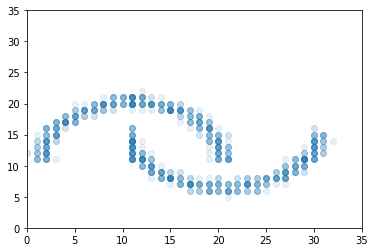

In [757]:
x = int_moons_sample(batch_size)
plt.scatter(x.argmax(-1)[:,0],x.argmax(-1)[:,1], alpha=0.1 )
plt.xlim(0,35); plt.ylim(0,35)

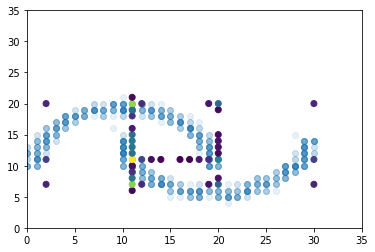

In [758]:
x = int_moons_sample(batch_size)
plt.scatter(x.argmax(-1)[:,0],x.argmax(-1)[:,1], alpha=0.1 )
plt.xlim(0,35); plt.ylim(0,35)
a = comb_high_probs.argmax(-1)
plt.scatter(a[:,0], a[:,1], c=high_probs, cmap=plt.get_cmap('viridis'))

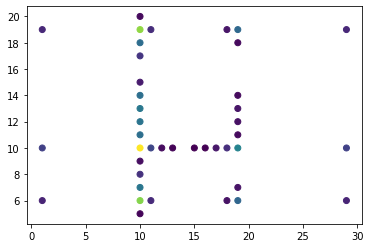

In [759]:
a = model.forward(comb_high_probs).argmax(-1)
plt.scatter(a[:,0], a[:,1], c=high_probs, cmap=plt.get_cmap('viridis'))

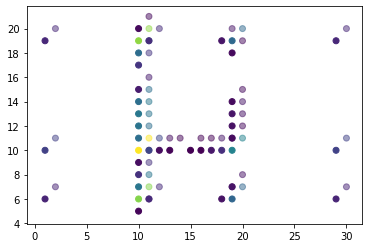

In [761]:
b=comb_high_probs.argmax(-1)
plt.scatter(b[:,0], b[:,1], c=high_probs, cmap=plt.get_cmap('viridis'),alpha=0.5)
plt.scatter(a[:,0], a[:,1], c=high_probs, cmap=plt.get_cmap('viridis'))

In [713]:
comb_high_probs.argmax(-1)[0:10,:]

tensor([[ 2,  7],
        [11,  7],
        [12,  7],
        [19,  7],
        [20,  7],
        [30,  7],
        [11,  8],
        [20,  8],
        [11,  9],
        [11, 10]])

In [714]:
a[:10,:]

tensor([[ 0,  5],
        [ 9,  5],
        [10,  5],
        [17,  5],
        [18,  5],
        [28,  5],
        [ 9,  6],
        [18,  6],
        [ 9,  7],
        [ 9,  8]])

In [671]:
comb_high_probs.shape

torch.Size([40, 2, 35])

In [672]:
# seeing what the highest possible scores can be. 



logprob = comb_high_probs*base_log_probs
-torch.sum(logprob)/comb_high_probs.shape[0]
    


tensor(5.2563)

# Scraps in making a one hot adder


In [364]:
inputs = torch.tensor(oh[:64,:,:]).float()
loc = layer(inputs)
loc = disc_utils.one_hot_argmax(loc, 0.1).type(inputs.dtype)
print(loc.shape)
disc_utils.one_hot_add(loc, inputs).shape

torch.Size([64, 2, 150])


torch.Size([64, 2, 151])

In [70]:
t_res_sub = disc_utils.one_hot_minus( inputs, loc )

In [34]:
torch.rfft(loc,3).shape

torch.Size([64, 2, 76, 2])

In [35]:
torch.rfft(inputs,3).shape

torch.Size([64, 2, 76, 2])

In [36]:
torch.irfft(torch.rfft(loc,3) * torch.rfft(inputs,3),3)

tensor([[[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        ...,

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]]],
       grad_fn=<SqueezeBackward1>)

In [37]:
torch.irfft(torch.rfft(loc,3) * torch.rfft(inputs,3),3).shape

torch.Size([64, 2, 151])

In [247]:
inp = torch.tensor([1,2,3,4,5]).float()-1
inp_oh = torch.zeros((5,5))
inp_oh = inp_oh.scatter_(1, inp.unsqueeze(1).long(), 1)

In [248]:
inp_oh.shape

torch.Size([5, 5])

In [298]:
shifter = disc_utils.one_hot_argmax(torch.rand((5,1,5)), 0.1)
#torch.softmax(torch.rand((5)), -1)
shifter

tensor([[[0., 0., 1., 0., 0.]],

        [[0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 0.]],

        [[0., 0., 1., 0., 0.]],

        [[1., 0., 0., 0., 0.]]])

In [299]:
torch.sum(torch.arange(5)*shifter)

tensor(8.)

In [300]:
shifter.shape

torch.Size([5, 1, 5])

In [348]:
shifter[0,0,:]

tensor([0., 0., 1., 0., 0.])

In [349]:
inp_oh[1,:] #0-3=-3%5 = 2
# 1-3=-2%5=3
# 1+3 = 4 % 5 = 1


# 1 - 2 = -1 %5  = 4
# 1+2 = 3%5 = 3

tensor([0., 1., 0., 0., 0.])

In [350]:
torch.einsum('...v,...uv->...u', inp_oh[1,:].float(), shift_mat[0,0,:,:].float())

tensor([0., 0., 0., 0., 1.])

In [351]:
shift_mat = torch.stack( 
    [torch.roll(shifter, i, dims=-1) for i in (range(5))],
    dim=-2).float()
shift_mat.shape


torch.Size([5, 1, 5, 5])

In [352]:
shift_mat[0,0,:,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [342]:
shift_mat[0,0,:,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [343]:
inp_oh.shape

torch.Size([5, 5])

In [344]:
shift_mat.shape

torch.Size([5, 1, 5, 5])

In [354]:
shifter[:,0,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])

In [353]:
inp_oh

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

In [362]:
shift_mat[0,0,:,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [359]:
shift_mat[0,0,:,:].T

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

In [360]:
shift_mat_T = torch.transpose(shift_mat,-1,-2)

In [361]:
torch.einsum('...v,...uv->...u', inp_oh.unsqueeze(1).float(), shift_mat_T.float())

tensor([[[0., 0., 1., 0., 0.]],

        [[0., 0., 1., 0., 0.]],

        [[1., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1.]]])

In [86]:
inputs.shape

TensorShape([64, 2, 150])

In [87]:
loc.shape

TensorShape([64, 2, 150])

In [273]:
import tensorflow as tf
import edward2 as ed2
loc = tf.constant(loc.detach().numpy())
inputs = tf.constant(inputs.detach().numpy())

In [371]:
import disc_utils

In [372]:
tor_add = disc_utils.one_hot_add_simple(inputs, loc)

/Users/trentonbricken/protein-gen/notebooks/disc_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = scale.type( inputs.dtype)


In [376]:
tor_add.shape

torch.Size([64, 2, 150])

In [375]:
j=4
print( tor_add[j,0,:].argmax(), loc[j,0,:].argmax(), inputs[j,0,:].argmax())

tensor(101) tensor(20) tensor(81)


In [283]:

res_add = ed2.tensorflow.layers.utils.one_hot_add(loc,inputs)
res_add[0,0,:].numpy().argmax()

91

In [284]:
loc[0,0,:].numpy().argmax()

20

In [285]:
inputs[0,0,:].numpy().argmax()

71

In [79]:
def one_hot_simp_add(inputs, shift):
  """Performs (inputs - shift) % vocab_size in the one-hot space.
  Args:
    inputs: Tensor of shape `[..., vocab_size]`. Typically a soft/hard one-hot
      Tensor.
    shift: Tensor of shape `[..., vocab_size]`. Typically a soft/hard one-hot
      Tensor specifying how much to shift the corresponding one-hot vector in
      inputs. Soft values perform a "weighted shift": for example,
      shift=[0.2, 0.3, 0.5] performs a linear combination of 0.2 * shifting by
      zero; 0.3 * shifting by one; and 0.5 * shifting by two.
  Returns:
    Tensor of same shape and dtype as inputs.
  """
  # TODO(trandustin): Implement with circular conv1d.
  inputs = tf.convert_to_tensor(inputs)
  shift = tf.cast(shift, inputs.dtype)
  vocab_size = inputs.shape[-1]
  
  # Form a [..., vocab_size, vocab_size] matrix. Each batch element of
  # inputs will vector-matrix multiply the vocab_size x vocab_size matrix. This
  # "shifts" the inputs batch element by the corresponding shift batch element.
  shift_matrix = tf.stack([tf.roll(shift, i, axis=-1)
                           for i in range(vocab_size)], axis=-2)
  outputs = tf.einsum('...v,...uv->...u', inputs, shift_matrix)
  return outputs

In [83]:
res_add_simple = one_hot_simp_add(inputs, -loc)


In [175]:
res_add

<tf.Tensor: id=966, shape=(64, 2, 150), dtype=float32, numpy=
array([[[-1.39077505e-08,  6.16050926e-08,  8.06805431e-08, ...,
          2.07518425e-09,  1.41010847e-08,  2.90336484e-08],
        [-4.53988704e-08, -1.05245928e-08, -3.14599333e-08, ...,
          2.92471771e-08, -4.65775791e-08,  8.32149425e-08]],

       [[-3.41733291e-08, -4.92956538e-08,  9.18260312e-08, ...,
         -6.81949146e-08,  3.31483285e-08, -1.94591241e-08],
        [ 3.76701365e-07,  2.26353151e-07,  1.23996514e-07, ...,
         -5.16586134e-08,  9.79530590e-09, -7.09407971e-07]],

       [[-1.29540766e-07,  3.38414630e-08, -3.11788995e-08, ...,
         -4.34769838e-08, -6.02295458e-09, -4.69469548e-08],
        [ 1.04904174e-07,  2.37671586e-07, -9.71124194e-08, ...,
         -5.45487637e-08, -5.72065382e-08,  1.21280365e-07]],

       ...,

       [[ 5.99026677e-08, -6.21348306e-08, -2.20887088e-07, ...,
          7.00678342e-08,  2.92297159e-07, -6.02593445e-07],
        [-1.31527585e-07,  2.42835814

In [84]:
res_add_simple[0,0,:5]

<tf.Tensor: id=2362, shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>

In [85]:
res_add == res_add_simple

<tf.Tensor: id=2363, shape=(64, 2, 150), dtype=bool, numpy=
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       ...,

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])>

In [64]:
res_sub = ed2.tensorflow.layers.utils.one_hot_minus(inputs, loc )

In [65]:
res_add[0,0,:5]

<tf.Tensor: id=1428, shape=(5,), dtype=float32, numpy=
array([-1.39077505e-08,  6.16050926e-08,  8.06805431e-08, -8.64888676e-08,
        1.04205597e-07], dtype=float32)>

In [73]:
res_sub.numpy() == t_res_sub.detach().numpy()

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       ...,

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])